In [1]:
import os
import numpy as np
from scipy.integrate import cumtrapz
from scipy.optimize import fsolve
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally
mpl.rcParams.update(mpl.rcParamsDefault)
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
Spectrum_fp = os.path.join('Spectrum_Import','AM15.csv')

In [3]:
# Spectrum Data
fn_1 = os.path.join('Spectrum_Import','AM15.csv')
fn_2 = os.path.join('Spectrum_Import','AM0.csv')

# Constants
k = 1.38064852e-23  # J/K 			  , boltzman constant
k_eV = 8.617333262145e-5 # eV/k 	  , Boltzman constant
h = 6.62607004e-34   # m^2 kg s^-1    , planck constant
c = 2.99792458e8     # m s^-1         , speed of light
eV = 1.6021766208e-19  # joule        , eV to joule
q = 1.6021766208e-19  # C             , elemental charge
T = 300 # K 						  , temperature

## Formulas & Methodology

In [4]:
S = pd.read_csv(fn_1, delimiter=',', header=0)
WL_1, solar_per_nm_1 = S.iloc[:,0], S.iloc[:,1]

# converting from wavelength to energy
E_1 = 1239.8 / WL_1  # eV

#to calculate the integrated power of the irradiance
total_power_1=np.trapz(solar_per_nm_1, x=WL_1)

# converting irradiance from per wavelength to per eV, as we will work in eV for later parts
solar_per_E_1 = solar_per_nm_1 * (eV/1e-9) * h * c / (eV*E_1)**2 # converting to W m^-2 eV^-1

# building the requested bandgaps to iterate over
Bandgap = np.arange(0.1, 4, 0.001)

# since the imported csv isnt equally spaced interpolation to get it equal:
# making the spacing equal to make the integration unbiased toward sizes
AM15 = np.interp(Bandgap, E_1[::-1], solar_per_E_1[::-1])  # W m^-2 eV^-1

# converting irradiance into photon flux (more useful)
AM15flux = AM15 / (Bandgap*eV)  # number of photon m^-2 eV^-1 s^-1
fluxcumm_1 = cumtrapz(AM15flux[::-1], Bandgap[::-1], initial=0) #[::-1] enables reverse order vector
fluxaboveE_1 = fluxcumm_1[::-1] * -1 # this is to compensate for working in reverse order (large->small vs small->large)

for n in range(0, len(fluxaboveE_1)): # this is to set everything above bandgap to 0 flux, # removing these loops will probably give a more realistic value
	if fluxaboveE_1[n] < 0:
		fluxaboveE_1[n] = 0 

# this now converts the photon flux to a Jsc in mA
Jsc_1 = fluxaboveE_1 * q / 10  # mA/cm^2  (/10: from A/m2 to mA/cm2)

# conversion of planck's black body radiation law eqn (10.18 Jager) to efficient photon flux as described by
# DOI:https://doi.org/10.1016/0927-0248(95)80004-2, following eqn. 8a-8d:
# Note: Increasing temperature (T), will increase J0, further limiting PV performance!
J0_prime =  (2 * q * np.pi * (Bandgap*eV)**2)  / ((c**2) * (h**3) * ((np.exp(Bandgap*eV / (k*T)) - 1)))

# now integrating over interested bandgaps (Bandgap*eV) in reverse: 
fluxcumm = cumtrapz(J0_prime[::-1], Bandgap[::-1], initial=0)
fluxaboveE = fluxcumm[::-1] * -1	
J0 = fluxaboveE * q / 10  # ( from A/m2 to mA/cm2)
J0[-1] = np.nan  # div by 0 error otherwise for Voc calc

# now calculating Voc using provided equation
Voc = (k_eV*T) * np.log((Jsc_1/J0) + 1)

# now calculating FF using provided equation
FF = ((q*Voc)/(k*T) - (np.log((q*Voc)/(k*T)+.72)))/(((q*Voc)/(k*T))+1)

# now calculating PCE using provided equation
PCE = 100*((Jsc_1*10 * Voc * FF) / total_power_1) # PCE in percent, Jsc was in mA so x10

In [5]:
def solve_SQ_limit(bandgap):
    
    fn_1 = os.path.join('Spectrum_Import','AM15.csv')
    WL_1, solar_per_nm_1 = S.iloc[:,0], S.iloc[:,1]

    E_1 = 1239.8 / WL_1  # eV

    total_power_1=np.trapz(solar_per_nm_1, x=WL_1)

    solar_per_E_1 = solar_per_nm_1 * (eV/1e-9) * h * c / (eV*E_1)**2 # converting to W m^-2 eV^-1

    Bandgap = np.arange(0.1, 4, 0.01)

    AM15 = np.interp(Bandgap, E_1[::-1], solar_per_E_1[::-1])  # W m^-2 eV^-1

    AM15flux = AM15 / (Bandgap*eV)  # number of photon m^-2 eV^-1 s^-1

    fluxcumm_1 = cumtrapz(AM15flux[::-1], Bandgap[::-1], initial=0) #[::-1] enables reverse order vector

    fluxaboveE_1 = fluxcumm_1[::-1] * -1 
    
    # this now converts the photon flux to a Jsc in mA
    Jsc_1 = fluxaboveE_1 * q / 10  # mA/cm^2  (/10: from A/m2 to mA/cm2)
    
    J0_prime =  (2 * q * np.pi * (Bandgap*eV)**2)  / ((c**2) * (h**3) * ((np.exp(Bandgap*eV / (k*T)) - 1)))

    # now integrating over interested bandgaps (Bandgap*eV) in reverse: 
    fluxcumm = cumtrapz(J0_prime[::-1], Bandgap[::-1], initial=0)
    fluxaboveE = fluxcumm[::-1] * -1	

    J0 = fluxaboveE * q / 10  # ( from A/m2 to mA/cm2)
    J0[-1] = np.nan  # div by 0 error otherwise for Voc calc

    # now calculating Voc using provided equation
    Voc = (k_eV*T) * np.log((Jsc_1/J0) + 1)

    # now calculating FF using provided equation
    FF = ((q*Voc)/(k*T) - (np.log((q*Voc)/(k*T)+.72)))/(((q*Voc)/(k*T))+1)

    # now calculating PCE using provided equation
    PCE = 100*((Jsc_1*10 * Voc * FF) / total_power_1) # PCE in percent, Jsc was in mA so x10
    
    
    PCE_answer = np.round(np.interp(bandgap, Bandgap, PCE), 4) # %
    FF_answer = np.round(np.interp(bandgap, Bandgap, FF), 4) # %
    Voc_answer = np.round(np.interp(bandgap, Bandgap, Voc), 4) # eV
    Jsc_answer = np.round(np.interp(bandgap, Bandgap, Jsc_1), 4)  # mA/cm^2
    J0_answer = np.interp(bandgap, Bandgap, J0)  # mA/cm^2
    SQ_limit = {'PCE': PCE_answer, 'FF': FF_answer, 'Jsc': Jsc_answer, 'Voc': Voc_answer, 'J0': J0_answer}
    
    return SQ_limit

In [7]:
solve_SQ_limit(1.67)

{'PCE': 29.4839,
 'FF': 0.9087,
 'Jsc': 23.3544,
 'Voc': 1.3898,
 'J0': 1.0501571937976296e-22}

AM1.5G total irradiance = 1000.3706555734423


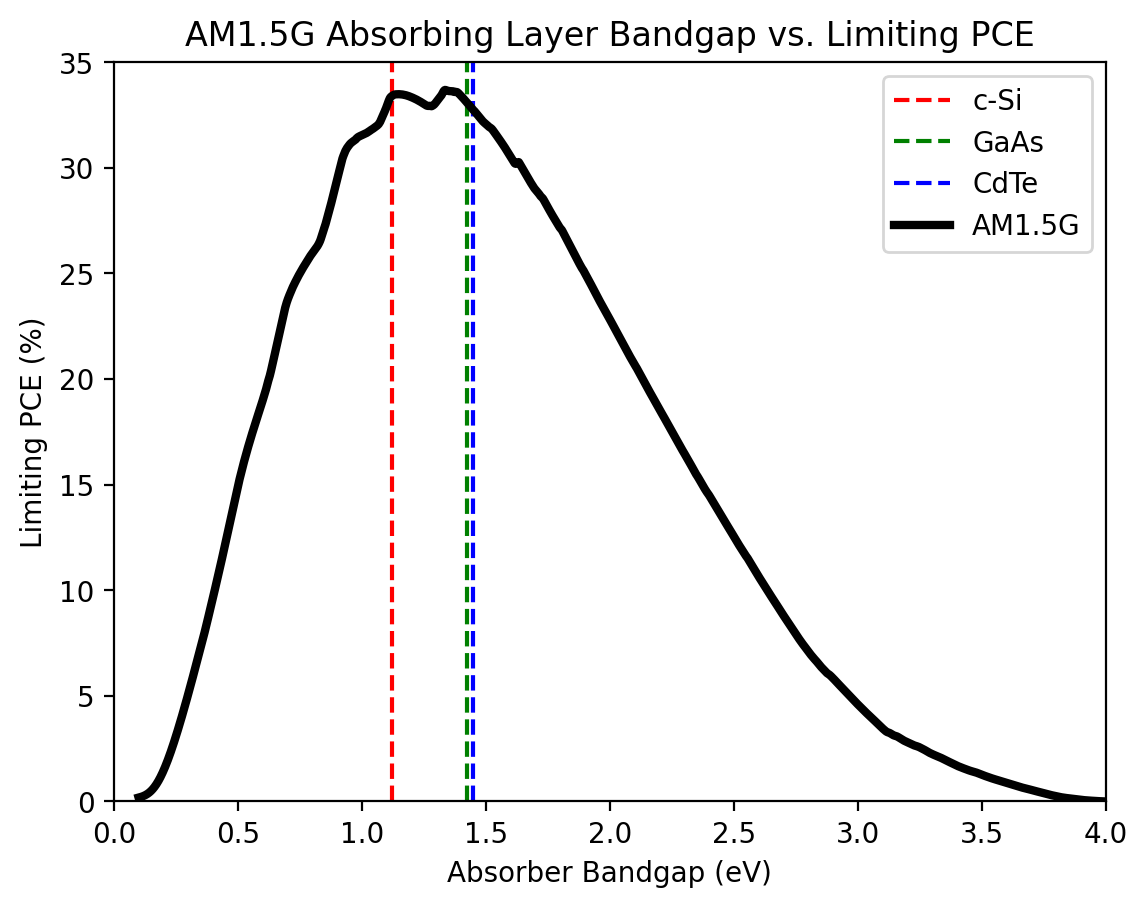

In [17]:
# Plotting
plt.figure(1)
ax1 = plt.plot(WL_1, solar_per_nm_1, label='AM1.5G')
plt.xlabel('Wavelength / nm')
plt.ylabel('Irradiance / W/(m2 nm1)')
plt.title('Solar Spectrum')
plt.legend()
# plt.show()
plt.close()


print('AM1.5G total irradiance =',total_power_1)


plt.figure(2)
ax1 = plt.plot(Bandgap, Jsc_1, label='AM1.5G', color='k')
plt.fill_between(Bandgap, Jsc_1, where=(Bandgap >= 1.73) & (Bandgap <= 1.9), color='green', alpha=0.2)
plt.fill_between(Bandgap, Jsc_1, where=(Bandgap >= 1.9) & (Bandgap <= 2.25), color='salmon', alpha=0.2)
plt.xlim(1.6,2.5)
plt.ylim(0,40)
plt.xlabel('Device Bandgap / eV')
plt.ylabel('Limiting Jsc / mA/cm2')
plt.title('Device Bandgap affecting limiting Jsc')
plt.legend()
plt.close()
# plt.close()



plt.figure(3)
ax1 = plt.semilogy(Bandgap, J0, label='AM1.5G')
plt.xlabel('Device Bandgap / eV')
plt.ylabel('Limiting J0 / mA/cm2')
plt.title('Device Bandgap affecting limiting J0')
plt.legend()
# plt.show()
plt.close()

plt.figure(4)
ax1 = plt.plot(Bandgap, Voc, label='AM1.5G')
plt.xlabel('Device Bandgap / eV')
plt.ylabel('Limiting Voc / V')
plt.title('Device Bandgap affecting limiting Voc')
plt.legend()
# plt.show()
plt.close()


plt.figure(5)
ax1 = plt.plot(Bandgap, FF*100, label='AM1.5G')
plt.xlabel('Device Bandgap / eV')
plt.ylabel('Limiting FF / %')
plt.title('Device Bandgap affecting limiting FF')
plt.legend()
# plt.show()
plt.close()


# The voltage extracted from a PV_device is equal to the difference between 
# the electron vs. hole quasi fermi level
# as explained in Voc eqn, there is a bandgap - losses due to dark current, hot-carriers
# in reality there is also losses due to SRH, NRR, auger

# part 1h) 
plt.figure(6)
plt.axvline(x= 1.12, ymin=0, ymax = 30, color='r', linestyle='--', label='c-Si')
plt.axvline(x= 1.424, ymin=0, ymax = 30, color='g', linestyle='--', label='GaAs')
plt.axvline(x= 1.45, ymin=0, ymax = 30, color='b', linestyle='--', label='CdTe')
plt.xlim(1.6,2.5)
plt.plot(Bandgap, PCE, label='AM1.5G', color='k', linewidth=3)
plt.xlim(0,4)
plt.ylim(0,35)
plt.xlabel('Absorber Bandgap (eV)')
plt.ylabel('Limiting PCE (%)')
plt.title('AM1.5G Absorbing Layer Bandgap vs. Limiting PCE')
plt.legend()
plt.show()
plt.close()